Выбранные темы: прогнозирование стоимости страховки, данные о населении, цены на автомобили.

Выделим вспомогательные функции

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import numpy as np

label_encoder = LabelEncoder()

# Функция для применения oversampling
def apply_oversampling(X, y):
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    return X_resampled, y_resampled

# Функция для применения undersampling
def apply_undersampling(X, y):
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    return X_resampled, y_resampled

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
):
    """
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    """

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))

    X = df_input  # Contains all columns.
    y = df_input[
        [stratify_colname]
    ]  # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

Анализ наборов данных

1) Прогнозирование стоимости страховки

Проблемная область: Медицинское страхование.

Описание: Набор данных содержит информацию о клиентах медицинского страхования, включая возраст, пол, индекс массы тела (ИМТ), количество детей, курение, регион и стоимость страхового взноса.

Связи между объектами: Нет явных связей, кроме того, что все объекты относятся к клиентам медицинского страхования.

Бизнес-цель: Оптимизация тарифов страховых взносов.

Эффект для бизнеса: Снижение рисков и повышение прибыльности за счет более точного определения стоимости страхования для разных групп клиентов.

Цель технического проекта: Разработка модели машинного обучения для прогнозирования стоимости страхового взноса на основе характеристик клиента.

Входные признаки: Возраст, пол, ИМТ, количество детей, курение, регион.

Целевой признак: Стоимость страхового взноса.

Данный график позволят увидеть изменения стоимости страховки от возраста.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
               age          bmi     children       charges
count  2772.000000  2772.000000  2772.000000   2772.000000
mean     39.109668    30.701349     1.101732  13261.369959
std      14.081459     6.129449     1.214806  12151.768945
min      18.000000    15.960000     0.000000   1121.873900
25%      26.000000    26.220000     0.000000   4687.797000
50%      39.00

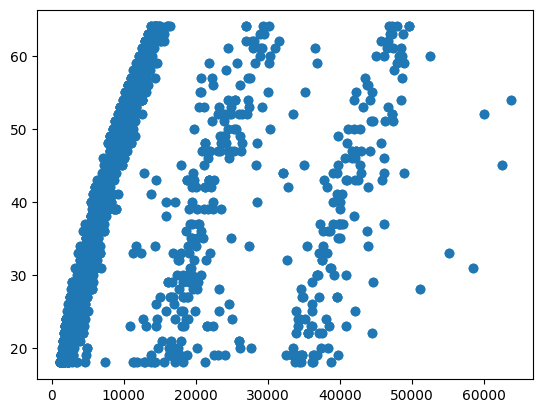

In [68]:
df1 = pd.read_csv("../data/Medical_insurance.csv")
df1.info()
print(df1.isnull().sum())
print(df1.describe())

plt.scatter(df1["charges"], df1["age"])
plt.show()

Зашумленность: Возможны ошибки в данных, например, некорректные значения ИМТ.

Смещение: Может быть смещение в данных, например, если выборка нерепрезентативна по полу или региону.

Актуальность: Данные должны быть актуальными, чтобы модель давала точные прогнозы.

Выбросы: Выбросы в данных, например, очень высокие значения стоимости страхового взноса.

Просачивание данных: Не должно быть просачивания данных, например, если стоимость страхового взноса используется в качестве признака.

Примеры решения обнаруженных проблем:

Зашумленность: Очистка данных, удаление или исправление ошибочных значений.

Смещение: Балансировка данных, использование техники выборки.

Актуальность: Использование актуальных данных.

Выбросы: Удаление выбросов или использование техники обработки выбросов.

Просачивание данных: Удаление целевого признака из обучающих данных.

Оценка:

Информативность: Высокая, так как данные содержат много релевантных признаков для прогнозирования стоимости страхового взноса.

Степень покрытия: Высокая, так как данные содержат информацию о большом количестве клиентов.

Соответствие реальным данным: Высокое, так как данные взяты из реальной базы данных медицинского страхования.

Согласованность меток: Высокая, так как данные имеют четко определенные метки.

Чтобы устранить проблемы прощенных строк, необходимо удалить строки с пропущенными значениями.

Разбиение набора данных на обучающую, контрольную и тестовую выборки

Также потребуется приращение данных, если выборки несбалансированы по какому-либо признаку

In [69]:
data = df1[["age", "charges", "children"]].copy()
data["Charges_Grouped"] = pd.cut(data["age"], bins=6, labels=False)

interval_counts = data["Charges_Grouped"].value_counts().sort_index()

min_samples_per_interval = 10
for interval, count in interval_counts.items():
    if count < min_samples_per_interval:
        data.loc[data["Charges_Grouped"] == interval, "Charges_Grouped"] = -1


df_insurance_train, df_insurance_val, df_insurance_test = split_stratified_into_train_val_test(
    data, stratify_colname="Charges_Grouped", frac_train=0.60, frac_val=0.20, frac_test=0.20)

print("Обучающая выборка: ", df_insurance_train.shape)
print(df_insurance_train["Charges_Grouped"].value_counts())

X_resampled, y_resampled = apply_oversampling(df_insurance_train, df_insurance_train["Charges_Grouped"])
df_insurance_train_adasyn = pd.DataFrame(X_resampled)

print("Обучающая выборка после oversampling: ", df_insurance_train_adasyn.shape)
print(df_insurance_train_adasyn["Charges_Grouped"].value_counts())

print("Контрольная выборка: ", df_insurance_val.shape)
print(df_insurance_val["Charges_Grouped"].value_counts())

print("Тестовая выборка: ", df_insurance_test.shape)
print(df_insurance_test["Charges_Grouped"].value_counts())

Обучающая выборка:  (1663, 4)
Charges_Grouped
0    386
4    277
1    271
2    251
3    244
5    234
Name: count, dtype: int64
Обучающая выборка после oversampling:  (2316, 4)
Charges_Grouped
3    386
5    386
0    386
1    386
4    386
2    386
Name: count, dtype: int64
Контрольная выборка:  (554, 4)
Charges_Grouped
0    129
4     92
1     90
2     84
3     81
5     78
Name: count, dtype: int64
Тестовая выборка:  (555, 4)
Charges_Grouped
0    129
4     93
1     91
2     83
3     81
5     78
Name: count, dtype: int64


Данные хорошо подходят для построения модели прогнозирования стоимости страхового взноса. Возможны проблемы с зашумленностью и смещением данных.

2. Цены на автомобили

Проблемная область: Автомобильная индустрия.

Описание: Набор данных содержит информацию о характеристиках автомобилей, таких как марка, модель, год выпуска, пробег, тип топлива, тип трансмиссии и цена продажи. Нет явных связей, кроме того, что все объекты относятся к автомобилям.

Бизнес-цель: Оптимизация ценообразования на вторичном рынке автомобилей.

Эффект для бизнеса: Увеличение продаж и прибыли за счет более точной оценки рыночной стоимости автомобилей.

Цель технического проекта: Разработка модели машинного обучения для прогнозирования рыночной стоимости автомобиля на основе его характеристик.

Входные признаки: Марка, модель, год выпуска, пробег, тип топлива, тип трансмиссии.

Целевой признак: Цена продажи.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

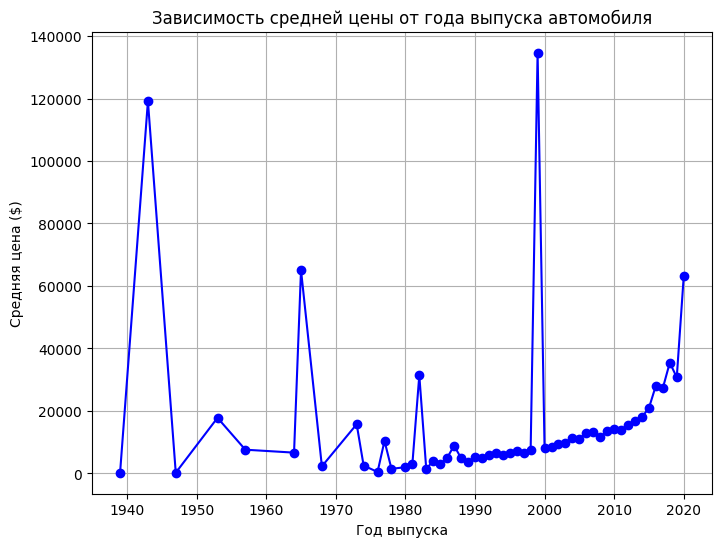

In [70]:
df2 = pd.read_csv("../data/car_price_prediction.csv")
df2.info()
print(df2.isnull().sum())
print(df2.describe())

mean_price_per_year = df2.groupby('Prod. year')['Price'].mean()
plt.figure(figsize=(8, 6))
mean_price_per_year.plot(kind='line', marker='o', color='blue')
plt.title('Зависимость средней цены от года выпуска автомобиля')
plt.xlabel('Год выпуска')
plt.ylabel('Средняя цена ($)')
plt.grid(True)
plt.show()

Зашумленность: Возможны ошибки в данных, например, некорректные значения пробега.

Смещение: Может быть смещение в данных, например, если выборка нерепрезентативна по марке или модели автомобиля.

Актуальность: Данные должны быть актуальными, чтобы модель давала точные прогнозы.

Выбросы: Возможны выбросы в данных, например, очень высокие или низкие значения цены продажи.

Просачивание данных: Не должно быть просачивания данных, например, если цена продажи используется в качестве признака.

Решение этих проблем:

Зашумленность: Очистка данных, удаление или исправление ошибочных значений.

Смещение: Балансировка данных, использование техники выборки.

Актуальность: Использование актуальных данных.

Выбросы: Удаление выбросов или использование техники обработки выбросов.

Просачивание данных: Удаление целевого признака из обучающих данных.

Оценка:

Информативность: Высокая, так как данные содержат много релевантных признаков для прогнозирования стоимости страхового взноса.

Степень покрытия: Высокая, так как данные содержат информацию о большом количестве клиентов.

Соответствие реальным данным: Высокое, так как данные взяты из реальной базы данных медицинского страхования.

Согласованность меток: Высокая, так как данные имеют четко определенные метки.

Разбиение набора данных на обучающую, контрольную и тестовую выборки

Также потребуется приращение данных, если выборки несбалансированы по какому-либо признаку

In [72]:
df2 = df2[df2['Price'] <= 10000000]

data = df2[["Price", "Prod. year", "Airbags"]].copy()
data["Price_Grouped"] = pd.cut(data["Price"], bins=50, labels=False)

interval_counts = data["Price_Grouped"].value_counts().sort_index()

min_samples_per_interval = 5
for interval, count in interval_counts.items():
    if count < min_samples_per_interval:
        data.loc[data["Price_Grouped"] == interval, "Price_Grouped"] = -1

df_price_train, df_price_val, df_price_test = split_stratified_into_train_val_test(
    data, stratify_colname="Price_Grouped", frac_train=0.60, frac_val=0.20, frac_test=0.20)

print("Обучающая выборка: ", df_price_train.shape)
print(df_price_train["Price_Grouped"].value_counts())


X_resampled, y_resampled = apply_oversampling(df_price_train, df_price_train["Price_Grouped"])
df_price_train_adasyn = pd.DataFrame(X_resampled)

print("Обучающая выборка после oversampling: ", df_price_train_adasyn.shape)
print(df_price_train_adasyn["Price_Grouped"].value_counts())


print("Контрольная выборка: ", df_price_val.shape)
print(df_price_val["Price_Grouped"].value_counts())

print("Тестовая выборка: ", df_price_test.shape)
print(df_price_test["Price_Grouped"].value_counts())

Обучающая выборка:  (11541, 4)
Price_Grouped
 0    7371
 1    2761
 2     935
 3     272
 4      96
 5      50
 6      22
 7      13
-1       9
 8       8
 9       4
Name: count, dtype: int64
Обучающая выборка после oversampling:  (81081, 4)
Price_Grouped
 0    7371
 1    7371
 2    7371
 5    7371
 3    7371
 4    7371
 7    7371
 6    7371
 8    7371
-1    7371
 9    7371
Name: count, dtype: int64
Контрольная выборка:  (3847, 4)
Price_Grouped
 0    2457
 1     920
 2     311
 3      91
 4      32
 5      17
 6       8
 7       4
 8       3
-1       3
 9       1
Name: count, dtype: int64
Тестовая выборка:  (3848, 4)
Price_Grouped
 0    2458
 1     921
 2     312
 3      90
 4      32
 5      17
 6       7
 7       4
 8       3
-1       3
 9       1
Name: count, dtype: int64


Данные хорошо подходят для построения модели прогнозирования цены продажи автомобиля. Возможны проблемы с зашумленностью и смещением данных.

3. Цены на кофе

Проблемная область: Финансы и инвестиции.

Описание: Набор данных содержит исторические данные о ценах на акции Starbucks (тикер: SBUX) с 1992 по 2021 год. Данные включают информацию о ценах открытия, закрытия, максимальных и минимальных ценах, объеме торгов и скорректированных ценах закрытия.

Связи между объектами: Данные представлены временным рядом, где каждая строка соответствует одному торговому дню. Между объектами существует временная зависимость, так как цены на акции зависят от предыдущих значений.

Бизнес-цель: Прогнозирование будущих цен на акции Starbucks.

Эффект для бизнеса:

Для инвесторов: Повышение точности прогнозов позволяет инвесторам принимать более обоснованные решения о покупке и продаже акций, что может привести к увеличению прибыли.

Для компании Starbucks: Понимание динамики цен на акции может помочь в разработке стратегий привлечения инвестиций и повышения рыночной стоимости компании.

Цель технического проекта: Разработка модели машинного обучения для прогнозирования цены закрытия акций Starbucks на следующий день.

Входные признаки:

Open (цена открытия)

High (максимальная цена)

Low (минимальная цена)

Close (цена закрытия)

Volume (объем торгов)

Adj Close (скорректированная цена закрытия)

Целевой признак: Close (цена закрытия на следующий день).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8036 entries, 0 to 8035
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8036 non-null   object 
 1   Open       8036 non-null   float64
 2   High       8036 non-null   float64
 3   Low        8036 non-null   float64
 4   Close      8036 non-null   float64
 5   Adj Close  8036 non-null   float64
 6   Volume     8036 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 439.6+ KB
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
              Open         High          Low        Close    Adj Close  \
count  8036.000000  8036.000000  8036.000000  8036.000000  8036.000000   
mean     30.054280    30.351487    29.751322    30.058857    26.674025   
std      33.615577    33.906613    33.314569    33.615911    31.728090   
min       0.328125     0.347656     0.320313     0.33593

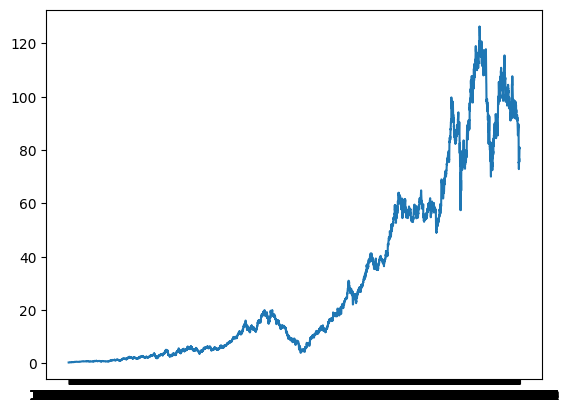

In [76]:
df3 = pd.read_csv("../data/Starbucks Dataset.csv")
df3.info()
print(df3.isnull().sum())
print(df3.describe())

plt.plot(df3["Date"], df3["High"])
plt.show()

Зашумленность: Возможны случайные колебания цен, которые могут быть вызваны внешними факторами.

Смещение: Нет явного смещения, так как данные представляют собой временной ряд.

Актуальность: Данные актуальны до 2021 года, но для более точного прогнозирования могут потребоваться более свежие данные.

Выбросы: Возможны выбросы в данных, например, резкие скачки цен, вызванные внешними событиями (кризисы, слияния и поглощения).

Просачивание данных: Не должно быть просачивания данных, так как целевой признак (цена закрытия на следующий день) не должен использоваться в качестве признака.

Примеры их решений:

Зашумленность: Использование методов сглаживания временных рядов, таких как скользящее среднее или экспоненциальное сглаживание.

Выбросы: Удаление выбросов или использование техники обработки выбросов, такой как Winsorization.

Актуальность: Обновление данных до последней доступной даты.

Оценка набора данных:

Информативность: Высокая, так как данные содержат много релевантных признаков для прогнозирования цен на акции.

Степень покрытия: Высокая, так как данные охватывают длительный период времени (1992-2021).

Соответствие реальным данным: Высокое, так как данные взяты из реальной торговой платформы.

Согласованность меток: Высокая, так как данные имеют четко определенные метки.

Выборки сбалансированы, так как данные представляют собой временной ряд, и каждая строка соответствует одному торговому дню.
Данные представлены в виде временного ряда, поэтому не требуется исмпользовать методы приращения данных.

Для временных рядов методы oversampling и undersampling обычно не применяются, так как они могут нарушить временную структуру данных.

In [78]:
data = df3[["Volume", "High", "Low"]].copy()
data["Volume_Grouped"] = pd.cut(data["Volume"], bins=50, labels=False)

interval_counts = data["Volume_Grouped"].value_counts().sort_index()

min_samples_per_interval = 5
for interval, count in interval_counts.items():
    if count < min_samples_per_interval:
        data.loc[data["Volume_Grouped"] == interval, "Volume_Grouped"] = -1


df_coffee_train, df_coffee_val, df_coffee_test = split_stratified_into_train_val_test(
    data, stratify_colname="Volume_Grouped", frac_train=0.60, frac_val=0.20, frac_test=0.20)

print("Обучающая выборка: ", df_coffee_train.shape)
print(df_coffee_train["Volume_Grouped"].value_counts())

print("Контрольная выборка: ", df_coffee_val.shape)
print(df_coffee_val["Volume_Grouped"].value_counts())

print("Тестовая выборка: ", df_coffee_test.shape)
print(df_coffee_test["Volume_Grouped"].value_counts())

Обучающая выборка:  (4821, 4)
Volume_Grouped
 0    2802
 1    1460
 2     369
 3     111
 4      40
 5      18
-1      10
 6       7
 7       4
Name: count, dtype: int64
Контрольная выборка:  (1607, 4)
Volume_Grouped
 0    934
 1    487
 2    123
 3     37
 4     13
 5      6
-1      4
 6      2
 7      1
Name: count, dtype: int64
Тестовая выборка:  (1608, 4)
Volume_Grouped
 0    934
 1    487
 2    124
 3     37
 4     14
 5      6
-1      3
 6      2
 7      1
Name: count, dtype: int64


Вывод:

Данные хорошо подходят для построения модели прогнозирования цен на акции Starbucks.

Возможны проблемы с зашумленностью и выбросами в данных.

Для улучшения качества модели можно использовать методы сглаживания временных рядов и обработки выбросов.